In [45]:
# Tratamento de warning
import warnings
warnings.filterwarnings('ignore')

#### Análise dos dados sobre acidentes em rodovias em território nacional, disponibilizados pela Polícia Rodoviária Federal (PRF), com objetivo de:

>- auxiliar o cidadão na tomada de decisão de usar uma estrada (br) em determinado mês do ano, fase do dia (manha, tarde, noite), feriado ou não e uf. Dessa forma, saber quais estradas e periodo do ano precisam de especial atenção para evitar acidentes fatais.

>- entender quais as principais causas de acidentes. 

>- nortear a decisão das autoridadess de onde investir em melhorias, recapeamento, postos policiais etc., com base na classificação, se estrada perigosa ou não (status).

Base de dados disponibilizada em https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-acidentes.

### Análise Exploratória do Dado

Além do pacote pandas, para lidar com data frames, o pacote holidays foi importado. Este pacote traz a informação das datas de feriados nacionais.

In [46]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import pandas as pd
import numpy as np
import holidays
pd.set_option('display.max_columns', None)
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
import plotly.express as px

In [47]:
cred = credentials.Certificate("./key/techfase3-firebase-adminsdk-fbsvc-e71cc04b8f.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

In [48]:
data_ref = db.collection("datatran")
results = data_ref .get()

In [49]:
data = [doc.to_dict() for doc in results]  
df = pd.DataFrame(data)

### Como banco de dados é gratuito, não é possível garantir que os dados estejam sempre disponíveis, entãoa criamos uma cópia local

In [ ]:
# import glob

# # Encontrar todos os arquivos CSV na pasta "dados"
# arquivos = glob.glob('./dados/*.csv')

# df = pd.concat([pd.read_csv(arquivo, encoding='latin1', delimiter=';') for arquivo in arquivos], ignore_index=True)

In [50]:
df.head()

,uso_solo,longitude,tracado_via,veiculos,causa_acidente,km,feridos_leves,regional,uf,feridos_graves,classificacao_acidente,ilesos,uop,condicao_metereologica,dia_semana,horario,data_inversa,municipio,id,fase_dia,tipo_acidente,ano,feridos,tipo_pista,mortos,delegacia,pessoas,sentido_via,ignorados,br,latitude
0,Não,-48.71546613,Curva,2,Manobra de mudança de faixa,70,0,SPRF-PA,PA,0,Com Vítimas Fatais,1,UOP01-DEL03-PA,Nublado,domingo,03:00:00,2024-01-21,SAO DOMINGOS DO ARAGUAIA,576139,Plena Noite,Colisão frontal,2024.0,0,Simples,1,DEL03-PA,2,Decrescente,0,230,-5.5079345
1,Sim,-44.35676617,Reta;Declive,5,Acessar a via sem observar a presença dos outr...,207,0,SPRF-MA,MA,0,Com Vítimas Fatais,1,UOP02-DEL01-MA,Céu Claro,sábado,10:44:00,2024-06-01,ITAPECURU MIRIM,604442,Pleno dia,Colisão lateral mesmo sentido,2024.0,0,Simples,1,DEL01-MA,4,Crescente,4,222,-3.39827306
2,Sim,-49.11773068,Reta,1,Reação tardia ou ineficiente do condutor,761,1,SPRF-TO,TO,0,Com Vítimas Feridas,0,UOP02-DEL01-TO,Céu Claro,quinta-feira,11:10:00,2024-07-04,ALVORADA,611965,Pleno dia,Tombamento,2024.0,1,Dupla,0,DEL01-TO,1,Decrescente,0,153,-12.48124904
3,Não,-34.9229207,Reta,3,Reação tardia ou ineficiente do condutor,25,2,SPRF-PE,PE,0,Com Vítimas Feridas,3,UOP02-DEL01-PE,Céu Claro,segunda-feira,07:34:00,2024-02-19,IGARASSU,581987,Pleno dia,Engavetamento,2024.0,2,Dupla,0,DEL01-PE,5,Crescente,0,101,-7.7009082
4,Não,"-49,08493",Reta,1,Reação tardia ou ineficiente do condutor,135,0,SPRF-GO,GO,0,Sem Vítimas,1,UOP01-DEL07-GO,Céu Claro,segunda-feira,20:35:00,2025-02-10,MARA ROSA,660608,Plena Noite,Saída de leito carroçável,2025.0,0,Simples,0,DEL07-GO,1,Crescente,0,153,"-13,949925"


In [51]:
df['data_inversa'] = df['data_inversa'].str.strip()
df['data_inversa'] = pd.to_datetime(df['data_inversa'], format='%Y-%m-%d', errors='coerce')
df['ano'] = pd.to_datetime(df['data_inversa'], errors='coerce').dt.year
df['mes'] = pd.to_datetime(df['data_inversa'], errors='coerce').dt.month

In [52]:
#df['ano'] = pd.to_numeric(df['ano'], errors='coerce').astype('Int64')
df['mortos'] = pd.to_numeric(df['mortos'], errors='coerce').astype('Int64')
df['feridos_graves'] = pd.to_numeric(df['feridos_graves'], errors='coerce').astype('Int64')
df['veiculos'] = pd.to_numeric(df['veiculos'], errors='coerce').astype('Int64')

In [53]:
df.head(3)

,uso_solo,longitude,tracado_via,veiculos,causa_acidente,km,feridos_leves,regional,uf,feridos_graves,classificacao_acidente,ilesos,uop,condicao_metereologica,dia_semana,horario,data_inversa,municipio,id,fase_dia,tipo_acidente,ano,feridos,tipo_pista,mortos,delegacia,pessoas,sentido_via,ignorados,br,latitude,mes
0,Não,-48.71546613,Curva,2,Manobra de mudança de faixa,70,0,SPRF-PA,PA,0,Com Vítimas Fatais,1,UOP01-DEL03-PA,Nublado,domingo,03:00:00,2024-01-21,SAO DOMINGOS DO ARAGUAIA,576139,Plena Noite,Colisão frontal,2024.0,0,Simples,1,DEL03-PA,2,Decrescente,0,230,-5.5079345,1.0
1,Sim,-44.35676617,Reta;Declive,5,Acessar a via sem observar a presença dos outr...,207,0,SPRF-MA,MA,0,Com Vítimas Fatais,1,UOP02-DEL01-MA,Céu Claro,sábado,10:44:00,2024-06-01,ITAPECURU MIRIM,604442,Pleno dia,Colisão lateral mesmo sentido,2024.0,0,Simples,1,DEL01-MA,4,Crescente,4,222,-3.39827306,6.0
2,Sim,-49.11773068,Reta,1,Reação tardia ou ineficiente do condutor,761,1,SPRF-TO,TO,0,Com Vítimas Feridas,0,UOP02-DEL01-TO,Céu Claro,quinta-feira,11:10:00,2024-07-04,ALVORADA,611965,Pleno dia,Tombamento,2024.0,1,Dupla,0,DEL01-TO,1,Decrescente,0,153,-12.48124904,7.0


In [55]:
df.shape

(19998, 32)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uso_solo                19998 non-null  object        
 1   longitude               19998 non-null  object        
 2   tracado_via             19998 non-null  object        
 3   veiculos                19996 non-null  Int64         
 4   causa_acidente          19998 non-null  object        
 5   km                      19998 non-null  object        
 6   feridos_leves           19998 non-null  object        
 7   regional                19998 non-null  object        
 8   uf                      19998 non-null  object        
 9   feridos_graves          19996 non-null  Int64         
 10  classificacao_acidente  19998 non-null  object        
 11  ilesos                  19998 non-null  object        
 12  uop                     19998 non-null  object

### Fazendo primeira inspeção para seleção de atributos com base no problema a ser resolvido

In [57]:
df.describe(include='all')

,uso_solo,longitude,tracado_via,veiculos,causa_acidente,km,feridos_leves,regional,uf,feridos_graves,classificacao_acidente,ilesos,uop,condicao_metereologica,dia_semana,horario,data_inversa,municipio,id,fase_dia,tipo_acidente,ano,feridos,tipo_pista,mortos,delegacia,pessoas,sentido_via,ignorados,br,latitude,mes
count,19998,19998,19998,19996.000000,19998,19998,19998,19998,19998,19996.000000,19998,19998,19998,19998,19998,19998,19995,19998,19998,19998,19998,19995.000000,19998,19998,19996.000000,19998,19998,19998,19998,19998,19998,19995.000000
unique,4,17259,339,NaN,69,5342,27,30,29,NaN,6,38,398,11,9,1152,389,1604,19997,6,18,NaN,31,5,NaN,156,49,5,17,107,17261,NaN
top,Não,-44.33422398,Reta,NaN,Reação tardia ou ineficiente do condutor,119,0,SPRF-MG,MG,NaN,Com Vítimas Feridas,1,UOP03-DEL01-MG,Céu Claro,sexta-feira,17:00:00,2025-01-01 00:00:00,BETIM,id,Pleno dia,Colisão traseira,NaN,1,Simples,NaN,DEL01-PR,2,Crescente,1,116,-20.16710798,NaN
freq,14176,12,10131,NaN,3101,59,8894,3048,3070,NaN,13771,9227,230,12694,3201,255,183,152,2,11805,4351,NaN,10740,11289,NaN,735,7106,10717,7860,3181,12,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2.824415,NaN,NaN,NaN,NaN,NaN,0.284207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.333933,NaN,NaN,0.146729,NaN,NaN,NaN,NaN,NaN,NaN,4.122131
std,NaN,NaN,NaN,1.468933,NaN,NaN,NaN,NaN,NaN,0.627687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.471628,NaN,NaN,0.479825,NaN,NaN,NaN,NaN,NaN,NaN,2.488985
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000


In [58]:
#Verificação de dados nulos
df.isnull().sum()

uso_solo                  0
longitude                 0
tracado_via               0
veiculos                  2
causa_acidente            0
km                        0
feridos_leves             0
regional                  0
uf                        0
feridos_graves            2
classificacao_acidente    0
ilesos                    0
uop                       0
condicao_metereologica    0
dia_semana                0
horario                   0
data_inversa              3
municipio                 0
id                        0
fase_dia                  0
tipo_acidente             0
ano                       3
feridos                   0
tipo_pista                0
mortos                    2
delegacia                 0
pessoas                   0
sentido_via               0
ignorados                 0
br                        0
latitude                  0
mes                       3
dtype: int64

In [59]:
datatran = df[['id', 'ano', 'mes', 'data_inversa', 'uf', 'br', 'km', 'municipio', 'causa_acidente', 'classificacao_acidente', 'veiculos', 'condicao_metereologica', 'fase_dia', 'dia_semana', 'tipo_acidente', 'tipo_pista', 'mortos', 'feridos_graves', 'latitude', 'longitude']]

In [60]:
datatran.head(3)

,id,ano,mes,data_inversa,uf,br,km,municipio,causa_acidente,classificacao_acidente,veiculos,condicao_metereologica,fase_dia,dia_semana,tipo_acidente,tipo_pista,mortos,feridos_graves,latitude,longitude
0,576139,2024.0,1.0,2024-01-21,PA,230,70,SAO DOMINGOS DO ARAGUAIA,Manobra de mudança de faixa,Com Vítimas Fatais,2,Nublado,Plena Noite,domingo,Colisão frontal,Simples,1,0,-5.5079345,-48.71546613
1,604442,2024.0,6.0,2024-06-01,MA,222,207,ITAPECURU MIRIM,Acessar a via sem observar a presença dos outr...,Com Vítimas Fatais,5,Céu Claro,Pleno dia,sábado,Colisão lateral mesmo sentido,Simples,1,0,-3.39827306,-44.35676617
2,611965,2024.0,7.0,2024-07-04,TO,153,761,ALVORADA,Reação tardia ou ineficiente do condutor,Com Vítimas Feridas,1,Céu Claro,Pleno dia,quinta-feira,Tombamento,Dupla,0,0,-12.48124904,-49.11773068


### Tratando valores ausentes:

In [64]:
selection = datatran[(datatran['classificacao_acidente'].isnull()) | (datatran['classificacao_acidente']=='NA')]
selection

,id,ano,mes,data_inversa,uf,br,km,municipio,causa_acidente,classificacao_acidente,veiculos,condicao_metereologica,fase_dia,dia_semana,tipo_acidente,tipo_pista,mortos,feridos_graves,latitude,longitude
4633,652555,2025.0,1.0,2025-01-01,RS,290,"27,1",SANTO ANTONIO DA PATRULHA,Demais falhas mecânicas ou elétricas,NA,2,Céu Claro,Pleno dia,quarta-feira,Saída de leito carroçável,Dupla,0,0,"-29,880135","-50,514297"
11623,571789,2024.0,1.0,2024-01-01,ES,101,38,CONCEICAO DA BARRA,Ultrapassagem Indevida,NA,3,Céu Claro,Plena Noite,segunda-feira,Colisão lateral sentido oposto,Simples,0,1,-18.48261,-39.92379


In [65]:
datatran['classificacao_acidente'].unique()

array(['Com Vítimas Fatais', 'Com Vítimas Feridas', 'Sem Vítimas', 'NA',
       'classificacao_acidente', '1'], dtype=object)

In [68]:
datatran.loc[
    ((datatran['classificacao_acidente'].isnull()) | (datatran['classificacao_acidente']=='NA')) & (datatran['mortos'] == 0) & (datatran['feridos_graves'] == 1),
    'classificacao_acidente'
] = "Com Vítimas Feridas"

datatran.loc[
    ((datatran['classificacao_acidente'].isnull()) | (datatran['classificacao_acidente']=='NA')) & (datatran['mortos'] == 0) & (datatran['feridos_graves'] == 0),
    'classificacao_acidente'
] = "Sem Vítimas"

In [69]:
datatran['classificacao_acidente'].unique()

array(['Com Vítimas Fatais', 'Com Vítimas Feridas', 'Sem Vítimas',
       'classificacao_acidente', '1'], dtype=object)

### Tratando valores ausentes:
>- dropna somente nas colunas que são essenciais para o modelo

In [70]:
#Remoção dos dados nulos
datatran.dropna(subset=['br','km', 'data_inversa', 'id' ], inplace=True)

In [71]:
datatran.isnull().sum()

id                        0
ano                       0
mes                       0
data_inversa              0
uf                        0
br                        0
km                        0
municipio                 0
causa_acidente            0
classificacao_acidente    0
veiculos                  0
condicao_metereologica    0
fase_dia                  0
dia_semana                0
tipo_acidente             0
tipo_pista                0
mortos                    0
feridos_graves            0
latitude                  0
longitude                 0
dtype: int64

In [72]:
datatran['uf'].unique()

array(['PA', 'MA', 'TO', 'PE', 'GO', 'MS', 'SC', 'DF', 'RJ', 'PR', 'CE',
       'SP', 'BA', 'RS', 'MG', 'ES', 'SE', 'RO', 'PB', 'MT', 'PI', 'RN',
       'AL', 'AC', 'RR', 'AP', 'AM'], dtype=object)

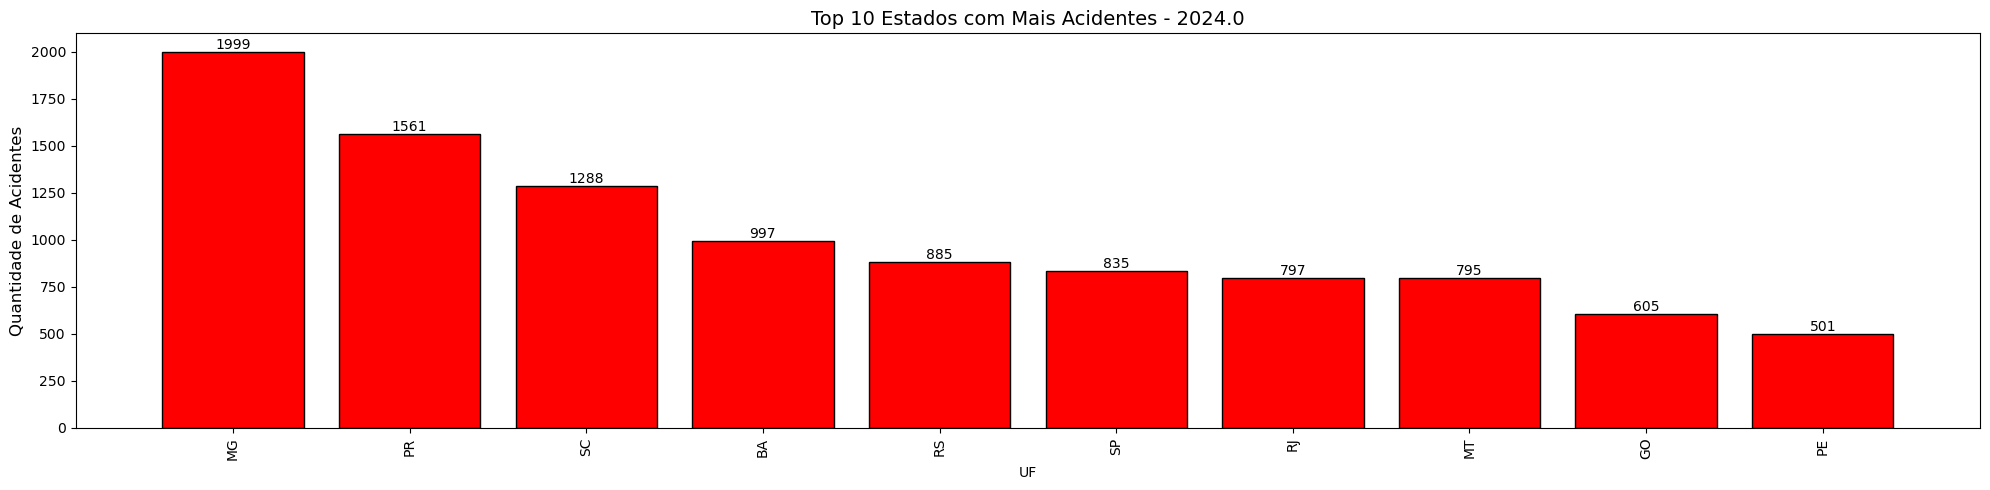

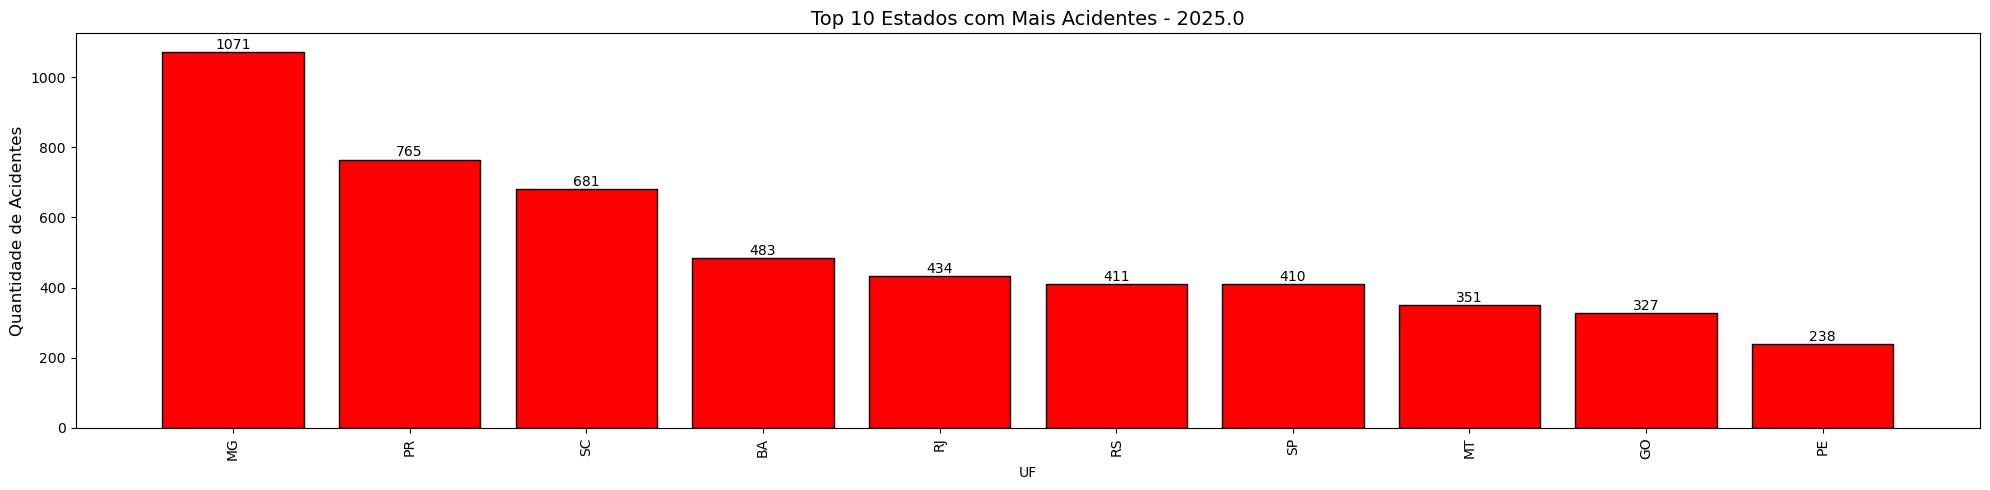

In [73]:
df_top = df.groupby(['ano', 'uf']).size().reset_index(name='QuantidadeAcidentesUF')

anos = df_top['ano'].unique()

for ano in anos:
    df_ano = df_top[df_top['ano'] == ano].sort_values(by='QuantidadeAcidentesUF', ascending=False).head(10)  # Top 10 UFs
    
    plt.figure(figsize=(20, 5))
    plt.bar(df_ano['uf'], df_ano['QuantidadeAcidentesUF'], color='red', edgecolor='black')
    plt.title(f'Top 10 Estados com Mais Acidentes - {ano}', fontsize=14)
    plt.xlabel('UF', fontsize=10)
    plt.ylabel('Quantidade de Acidentes', fontsize=12)
    
    # Adicionar valores sobre as barras
    for i, valor in enumerate(df_ano['QuantidadeAcidentesUF']):
        plt.text(i, valor + 0.1, str(valor), ha='center', va='bottom', fontsize=10, color='black')
    
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Inspecionando o atributo "classificação_acidente":

In [74]:
datatran['classificacao_acidente'].unique()

array(['Com Vítimas Fatais', 'Com Vítimas Feridas', 'Sem Vítimas'],
      dtype=object)

### Identificando Rodovia perigosa ou não com base nos mortos e	feridos_graves	

In [79]:
datatran['status'] = np.where(
    (datatran['mortos'].fillna(0) > 0) | (datatran['feridos_graves'].fillna(0) > 0),
    'Perigosa',
    'Segura'
)


In [80]:
datatran['status'].value_counts()

Segura      13393
Perigosa     6602
Name: status, dtype: int64

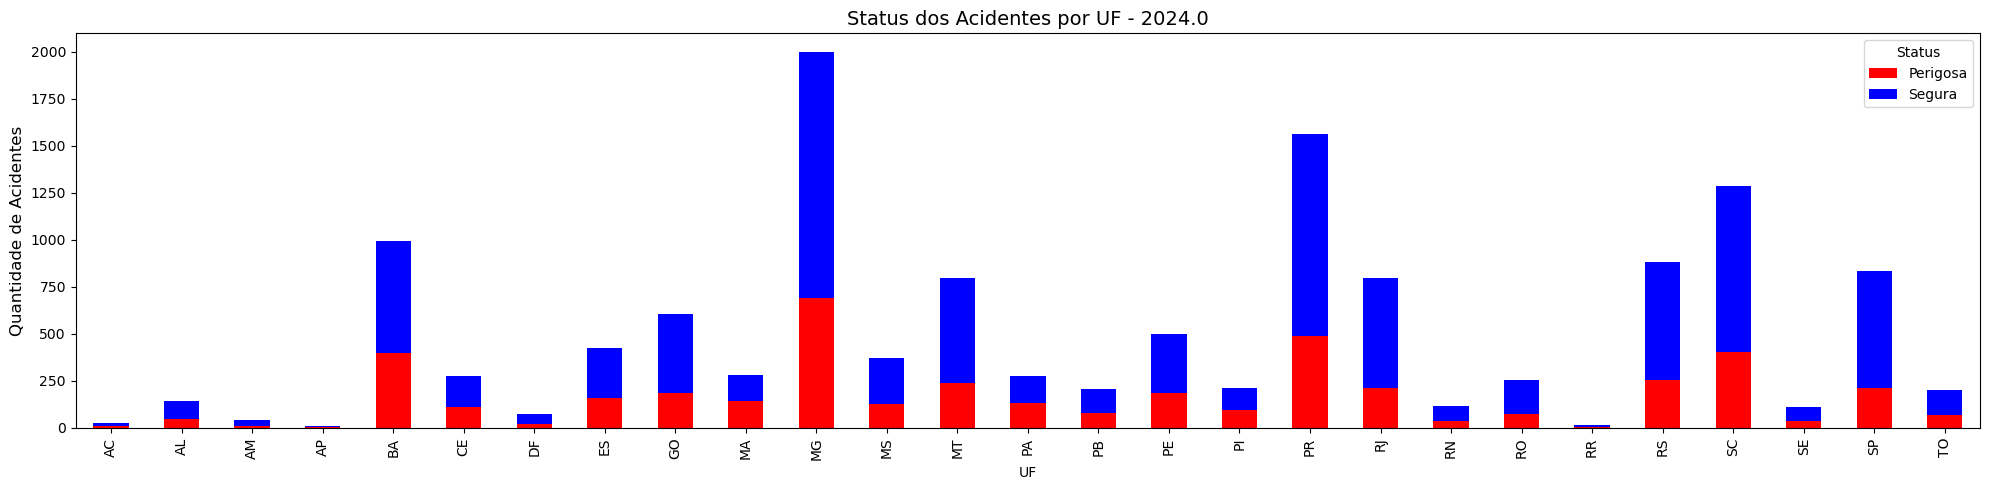

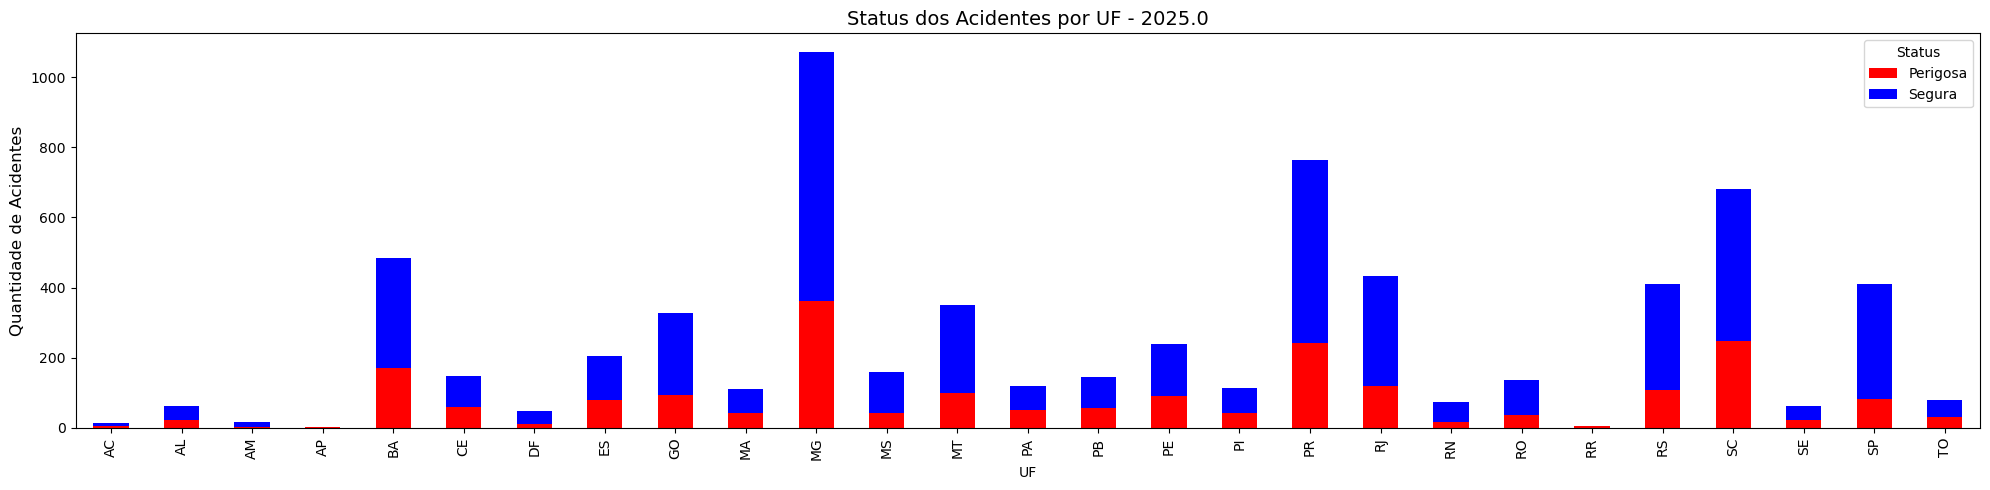

In [81]:
# Contar quantidade de acidentes por status, ano e UF
df_top = datatran.groupby(['ano', 'uf', 'status']).size().reset_index(name='StatusAcidentes')

# Criar gráficos para cada ano
anos = df_top['ano'].unique()

for ano in anos:
    df_ano = df_top[df_top['ano'] == ano]
    
    # Reestruturar os dados para garantir que todas as categorias sejam exibidas corretamente
    df_pivot = df_ano.pivot(index='uf', columns='status', values='StatusAcidentes').fillna(0)

    # Criar gráfico de barras empilhadas
    df_pivot.plot(kind='bar', stacked=True, figsize=(20, 5), color={'Perigosa': 'red', 'Segura': 'blue'})
    
    plt.title(f'Status dos Acidentes por UF - {ano}', fontsize=14)
    plt.xlabel('UF', fontsize=10)
    plt.ylabel('Quantidade de Acidentes', fontsize=12)
    plt.legend(title="Status")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Inspeção do dado

In [83]:
datatran['ano'].value_counts()

2024.0    13318
2025.0     6677
Name: ano, dtype: int64

In [84]:
datatran['dia_semana'].unique()

array(['domingo', 'sábado', 'quinta-feira', 'segunda-feira',
       'terça-feira', 'sexta-feira', 'quarta-feira'], dtype=object)

In [85]:
datatran['municipio'].unique()

array(['SAO DOMINGOS DO ARAGUAIA', 'ITAPECURU MIRIM', 'ALVORADA', ...,
       'SETE DE SETEMBRO', 'AMAPA', 'UBAJARA'], dtype=object)

In [86]:
datatran['fase_dia'].unique()

array(['Plena Noite', 'Pleno dia', 'Amanhecer', 'Anoitecer'], dtype=object)

In [87]:
datatran['br'].unique()

array(['230', '222', '153', '101', '158', '20', '116', '459', '354',
       '373', '163', '242', '435', '290', '262', '365', '280', '452',
       '470', '10', '364', '40', '287', '324', '304', '267', '251', '232',
       '386', '277', '472', '135', '110', '316', '356', '376', '381',
       '226', '60', '392', '50', '349', '343', '487', '70', '282', '493',
       '423', '428', '285', '448', '471', '393', '0', '407', '414', '476',
       '235', '174', '210', '104', '369', '319', '80', '415', '410',
       '405', '293', '418', '424', '480', '421', '408', '406', '427',
       '425', '146', '468', '259', '465', '495', '330', '402', '367',
       '155', '463', '156', '420', '308', '317', '401', '436', '361',
       '467', '272', '432', '412', '429', '488', '122', '359', '469',
       '484', '30', '419'], dtype=object)

### Removendo br = 0

In [88]:
datatran = datatran[datatran['br'] != 0]

In [89]:
datatran['br'].unique()

array(['230', '222', '153', '101', '158', '20', '116', '459', '354',
       '373', '163', '242', '435', '290', '262', '365', '280', '452',
       '470', '10', '364', '40', '287', '324', '304', '267', '251', '232',
       '386', '277', '472', '135', '110', '316', '356', '376', '381',
       '226', '60', '392', '50', '349', '343', '487', '70', '282', '493',
       '423', '428', '285', '448', '471', '393', '0', '407', '414', '476',
       '235', '174', '210', '104', '369', '319', '80', '415', '410',
       '405', '293', '418', '424', '480', '421', '408', '406', '427',
       '425', '146', '468', '259', '465', '495', '330', '402', '367',
       '155', '463', '156', '420', '308', '317', '401', '436', '361',
       '467', '272', '432', '412', '429', '488', '122', '359', '469',
       '484', '30', '419'], dtype=object)

In [90]:
datatran['causa_acidente'].unique()

array(['Manobra de mudança de faixa',
       'Acessar a via sem observar a presença dos outros veículos',
       'Reação tardia ou ineficiente do condutor',
       'Ausência de reação do condutor', 'Frear bruscamente',
       'Demais falhas mecânicas ou elétricas', 'Transitar na contramão',
       'Condutor Dormindo', 'Velocidade Incompatível',
       'Entrada inopinada do pedestre',
       'Objeto estático sobre o leito carroçável',
       'Acumulo de água sobre o pavimento', 'Pedestre andava na pista',
       'Ultrapassagem Indevida',
       'Trafegar com motocicleta (ou similar) entre as faixas',
       'Condutor deixou de manter distância do veículo da frente',
       'Pedestre cruzava a pista fora da faixa',
       'Ingestão de álcool pelo condutor', 'Problema com o freio',
       'Acesso irregular', 'Retorno proibido', 'Pista Escorregadia',
       'Desrespeitar a preferência no cruzamento', 'Pista esburacada',
       'Conversão proibida', 'Avarias e/ou desgaste excessivo no pneu'

In [91]:
datatran['condicao_metereologica'].unique()

array(['Nublado', 'Céu Claro', 'Chuva', 'Garoa/Chuvisco', 'Ignorado',
       'Nevoeiro/Neblina', 'Sol', 'Granizo', 'Vento'], dtype=object)

In [92]:
aux = datatran.query("condicao_metereologica == 'Céu Claro'")
aux['fase_dia'].unique()

array(['Pleno dia', 'Plena Noite', 'Amanhecer', 'Anoitecer'], dtype=object)

### Tratanto "condicao_metereologica" = "Ignorado"
>- assumindo que não foi importante registrar a condição metereológica, atribuiremos "Céu Claro" ( no contexto real, certificar com o dono do dado qual o tratamento adequado)

In [93]:
datatran['condicao_metereologica'].replace('Ignorado', 'Céu Claro', inplace=True)
datatran['condicao_metereologica'].unique()

array(['Nublado', 'Céu Claro', 'Chuva', 'Garoa/Chuvisco',
       'Nevoeiro/Neblina', 'Sol', 'Granizo', 'Vento'], dtype=object)

In [94]:
datatran['tipo_pista'].unique()

array(['Simples', 'Dupla', 'Múltipla'], dtype=object)

#### Analisando se data era ou não um feriado nacional pois isso pode ser um fator determinante para aumento de fluxo de veiculos e acidentes.


In [95]:
datatran.insert(2, 'feriado', '')
feriado = []
for i in holidays.Brazil()['2022-01-01':'2025-12-31']:
    feriado.append(i)
datatran['feriado'] = datatran['data_inversa'].isin(feriado)
datatran['feriado'].replace(True, 'y', inplace=True)
datatran['feriado'].replace(False, 'n', inplace=True)
datatran['feriado'].unique()

array(['n', 'y'], dtype=object)

### AGRUPANDO OS DADOS DAS COLUNAS 'uf' e 'mes' para diminuir a dimensionalidade quando encoding

In [96]:
# Dicionário mapeando as UFs para suas respectivas regiões
regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

# Função para mapear UF à região correspondente
def mapear_regiao(uf):
    for regiao, estados in regioes.items():
        if uf in estados:
            return regiao
    return 'Desconhecido'  # Caso haja alguma UF inválida

# Criando a coluna 'Região' no DataFrame
datatran['regiao'] = datatran['uf'].apply(mapear_regiao)

In [97]:
datatran['regiao'].unique()

array(['Norte', 'Nordeste', 'Centro-Oeste', 'Sul', 'Sudeste'],
      dtype=object)

In [98]:
# Criando um dicionário para mapear meses aos trimestres
trimestres = {
    1: '1 Trimestre', 2: '1 Trimestre', 3: '1 Trimestre',
    4: '2 Trimestre', 5: '2 Trimestre', 6: '2 Trimestre',
    7: '3 Trimestre', 8: '3 Trimestre', 9: '3 Trimestre',
    10: '4 Trimestre', 11: '4 Trimestre', 12: '4 Trimestre'
}

# Aplicando a lógica ao DataFrame
datatran['periodo'] = datatran['mes'].map(trimestres)

In [99]:
datatran['periodo'].unique()

array(['1 Trimestre', '2 Trimestre', '3 Trimestre'], dtype=object)

In [104]:
datatran[['regiao', 'br']].drop_duplicates()

,regiao,br
0,Norte,230
1,Nordeste,222
2,Norte,153
3,Nordeste,101
4,Centro-Oeste,153
...,...,...
12294,Sudeste,484
12828,Sudeste,0
12919,Centro-Oeste,242
13504,Nordeste,30


In [100]:
datatran.head()

,id,ano,feriado,mes,data_inversa,uf,br,km,municipio,causa_acidente,classificacao_acidente,veiculos,condicao_metereologica,fase_dia,dia_semana,tipo_acidente,tipo_pista,mortos,feridos_graves,latitude,longitude,status,regiao,periodo
0,576139,2024.0,n,1.0,2024-01-21,PA,230,70,SAO DOMINGOS DO ARAGUAIA,Manobra de mudança de faixa,Com Vítimas Fatais,2,Nublado,Plena Noite,domingo,Colisão frontal,Simples,1,0,-5.5079345,-48.71546613,Perigosa,Norte,1 Trimestre
1,604442,2024.0,n,6.0,2024-06-01,MA,222,207,ITAPECURU MIRIM,Acessar a via sem observar a presença dos outr...,Com Vítimas Fatais,5,Céu Claro,Pleno dia,sábado,Colisão lateral mesmo sentido,Simples,1,0,-3.39827306,-44.35676617,Perigosa,Nordeste,2 Trimestre
2,611965,2024.0,n,7.0,2024-07-04,TO,153,761,ALVORADA,Reação tardia ou ineficiente do condutor,Com Vítimas Feridas,1,Céu Claro,Pleno dia,quinta-feira,Tombamento,Dupla,0,0,-12.48124904,-49.11773068,Segura,Norte,3 Trimestre
3,581987,2024.0,n,2.0,2024-02-19,PE,101,25,IGARASSU,Reação tardia ou ineficiente do condutor,Com Vítimas Feridas,3,Céu Claro,Pleno dia,segunda-feira,Engavetamento,Dupla,0,0,-7.7009082,-34.9229207,Segura,Nordeste,1 Trimestre
4,660608,2025.0,n,2.0,2025-02-10,GO,153,135,MARA ROSA,Reação tardia ou ineficiente do condutor,Sem Vítimas,1,Céu Claro,Plena Noite,segunda-feira,Saída de leito carroçável,Simples,0,0,"-13,949925","-49,08493",Segura,Centro-Oeste,1 Trimestre


### SALVANDO DF COMO VARIÁVEL GLOBAL PARA CONTINUAR O PROJETO NO OUTRO NOTEBOOK:

>- 2 Machine Learning.ipynb
>- 3 LDA para topic model.ipynb

In [101]:
%store datatran

Stored 'datatran' (DataFrame)


In [102]:
datatran.to_csv('./resultados/datatran.csv', index=False, sep=';')